In [1]:
import copy
import io
import json
from collections import defaultdict
from tqdm import tqdm
import click
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages
from openff.toolkit.topology import Molecule
from PIL import Image
from simtk import unit
from tabulate import tabulate
from visualization import show_oemol_struc
from cinnabar.stats import bootstrap_statistic
import warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_2410581/1456711202.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
PARTICLE = unit.mole.create_unit(
    6.02214076e23 ** -1,
    "particle",
    "particle",
)
HARTREE_PER_PARTICLE = unit.hartree / PARTICLE
HARTREE_TO_KCALMOL = HARTREE_PER_PARTICLE.conversion_factor_to(
    unit.kilocalorie_per_mole
)
BOLTZMANN_CONSTANT = unit.constants.BOLTZMANN_CONSTANT_kB
REF_SPEC = 'mp2/heavy-aug-cc-pv[tq]z + d:ccsd(t)/heavy-aug-cc-pvdz'

In [3]:
def get_relative_energies(energies, conv_factor):
    min_energy = min(energies)
    energies = [conv_factor*(ener - min_energy) for ener in energies]
    return energies

def get_torsion_barrier(energies, angles):
    """
    gets the torsion barrier as the maximum barrier among the barriers present in the torsion profile
    Parameters
    ----------
    energies: list of energies along a torsion profile, can be MM or QM (y-axis values)
    angles: list of corresponding angles (x-axis values)

    Returns
    -------
    torsion_barriers: torsion barriers in the provided energy units
    """
    idx = []

    angles = np.array(angles) * np.pi / 180
    if len(angles) == 24:
        # appending the first three and last three energies to the end and beginning energies so as 
        # to have a continuous curve and all barriers at the edge are also covered
        angles = np.append(
            angles[-3:] - 2 * np.pi, np.append(angles, angles[:3] + 2 * np.pi)
        )
        energies = np.append(energies[-3:], np.append(energies, energies[:3]))

        for i in range(len(angles) - 2):
            m1 = (energies[i + 1] - energies[i]) / (angles[i + 1] - angles[i])
            m2 = (energies[i + 2] - energies[i + 1]) / (angles[i + 2] - angles[i + 1])
            if np.sign(m1) == np.sign(m2):
                continue
            else:
                idx.append(i + 1)
        torsion_barriers = []
        for i in range(int(len(idx) - 1)):
            torsion_barriers.append(abs(energies[idx[i]] - energies[idx[i + 1]]))

        torsion_barriers = np.array(torsion_barriers)
        return max(torsion_barriers)
    else:
        torsion_barrier = np.max(energies) - np.min(energies)
        return torsion_barrier


In [4]:

KELLYS_COLORS = [
    "#ebce2b",
    "#db6917",
    "#96cde6",
    "#ba1c30",
    "#fecb00",
    "#c0bd7f",
    "#7f7e80",
    "#5fa641",
    "#d485b2",
    "#4277b6",
    "#92ae31",
    "#463397",
    "#e1a11a",
    "#6f340d",
    "#e8e948",
    "#d32b1e",
    "#df8461",
    "#2b3514",
    "#702c8c",
    "#7e1510",
    "#91218c",
    "#01a263",
    "#fecb00",
    "#cd0d2d",
    "#00247d",
    "#ebce2b",
    "#db6917",
    "#96cde6",
]
pdf = PdfPages("./output/torsion_profiles_all_methods.pdf")
# for the sake of querying convenience listing out the keywords, methods and basis_sets sets explicitly
keywords_list = [
    "b97-d3bj/def2-tzvp",
    "m05-2x-d3/dzvp",
    "m06-2x-d3/dzvp",
    "m08-hx-d3/dzvp",
    "wb97x-d3bj/dzvp",
    "wb97m-d3bj/dzvp",
    "wb97m-v/dzvp",
    "pw6b95-d3bj/dzvp",
    "pw6b95-d3/dzvp",
    "mp2/aug-cc-pvtz",
    "mp2/heavy-aug-cc-pvtz",
    "dsd-blyp-d3bj/heavy-aug-cc-pvtz",
    "b3lyp-d3bj/dzvp",
    "b3lyp-d3mbj/dzvp",
    "b3lyp-nl/dzvp",
    "b3lyp-d3bj/def2-sv(p)",
    "b3lyp-d3bj/def2-svp",
    "b3lyp-d3bj/def2-tzvp",
    "b3lyp-d3bj/def2-tzvpd",
    "b3lyp-d3bj/def2-tzvpp",
    "b3lyp-d3bj/def2-tzvppd",
    "b3lyp-d3bj/def2-qzvp",
    "b3lyp-d3bj/6-31g*",
    "b3lyp-d3bj/6-31+g**",
    "b3lyp-d3bj/6-311+g**",
]
markers = ['$b$', '$m$', '$m$', '$m$','$\omega$', '$\omega$','$\omega$','v', 'v','*','*','s', 'D', 'P', 'P','X', 'X','^','^','^','^','$q$','$g$','$g$','$g$']

In [6]:
rmse = defaultdict(dict)
neutral_rmse = defaultdict(dict)
charged_rmse = defaultdict(dict)
mae = defaultdict(dict)
table = []
rcParams.update({"font.size": 12})
with open('./data/'+REF_SPEC.replace('/','_')+'_single_points_data.json', 'r') as file:
        ref_dict = json.load(file)
with open('./data/MP2_heavy-aug-cc-pVTZ_torsiondrive_data.json', 'r') as file:
    mp2_data = json.load(file)

all_barriers = defaultdict(list)
all_diff_with_ref = defaultdict(list)
neutral_barriers = defaultdict(list)
charged_barriers = defaultdict(list)
neutral_ref = []
charged_ref = []
all_ref = []

for i in range(59):
    ref_energies = np.array(get_relative_energies(ref_dict[str(i)]['total energies'], HARTREE_TO_KCALMOL))
    ref_angles = ref_dict[str(i)]['angles']
    ref_barrier = get_torsion_barrier(ref_energies, ref_angles)
    mapped_smiles = mp2_data[str(i)]['metadata']['mapped_smiles']
    dihedrals = mp2_data[str(i)]['metadata']['dihedral scanned'][0]
    mol_charge = mp2_data[str(i)]['metadata']['mol_charge']
    offmol = Molecule.from_mapped_smiles(mapped_smiles)
    flag_neutral = True
    if mol_charge != 0:
        flag_neutral = False
    elif mol_charge == 0  and mapped_smiles.find('+') != -1:
        flag_neutral = False
    
    all_ref.append(ref_barrier)
    if flag_neutral:
        neutral_ref.append(ref_barrier)
    else:
        charged_ref.append(ref_barrier)
        

    for k, key in enumerate(keywords_list):
        if key == 'mp2/heavy-aug-cc-pvtz':
            angles = mp2_data[str(i)]['angles']
            energies = np.array(get_relative_energies(mp2_data[str(i)]['final_energies'], HARTREE_TO_KCALMOL))
        else:
            with open('./data/'+key.replace('/','_')+'_single_points_data.json', 'r') as file:
                key_dict = json.load(file)
        
            angles = key_dict[str(i)]['angles']
            energies = np.array(get_relative_energies(key_dict[str(i)]['total energies'], HARTREE_TO_KCALMOL))
        
        
        barrier = get_torsion_barrier(energies, angles)   
        rmse_barrier = np.sqrt(np.mean((barrier - ref_barrier) ** 2))
        rmse[i][key] = rmse_barrier
        
        
        all_barriers[key].append(barrier)
        all_diff_with_ref[key].append(abs(barrier - ref_barrier))
        if flag_neutral:
            neutral_barriers[key].append(barrier)
            neutral_rmse[i][key] = rmse_barrier
        else:
            charged_barriers[key].append(barrier)
            charged_rmse[i][key] = rmse_barrier
            



In [7]:
for k, key in tqdm(enumerate(keywords_list)):    
    all_ref = np.array(all_ref)
    method_barriers = np.array(all_barriers[key])
    rmse_stats = bootstrap_statistic(y_true=all_ref, y_pred=method_barriers, statistic='RMSE')
    mue_stats = bootstrap_statistic(y_true=all_ref, y_pred=method_barriers, statistic='MUE')   
    neutral_stats = bootstrap_statistic(y_true=neutral_ref, y_pred=np.array(neutral_barriers[key]), statistic='RMSE')
    charged_stats = bootstrap_statistic(y_true=charged_ref, y_pred=np.array(charged_barriers[key]), statistic='RMSE')
    table.append([key,
                  "%.4f" % rmse_stats['mle'],"%.4f" % rmse_stats['low'],"%.4f" % rmse_stats['high'],
                  "%.4f" % mue_stats['mle'],"%.4f" % mue_stats['low'],"%.4f" % mue_stats['high'],
                  "%.4f" % neutral_stats['mle'],"%.4f" % neutral_stats['low'],"%.4f" % neutral_stats['high'],
                  "%.4f" % charged_stats['mle'],"%.4f" % charged_stats['low'],"%.4f" % charged_stats['high'],
                  ])

25it [00:44,  1.77s/it]


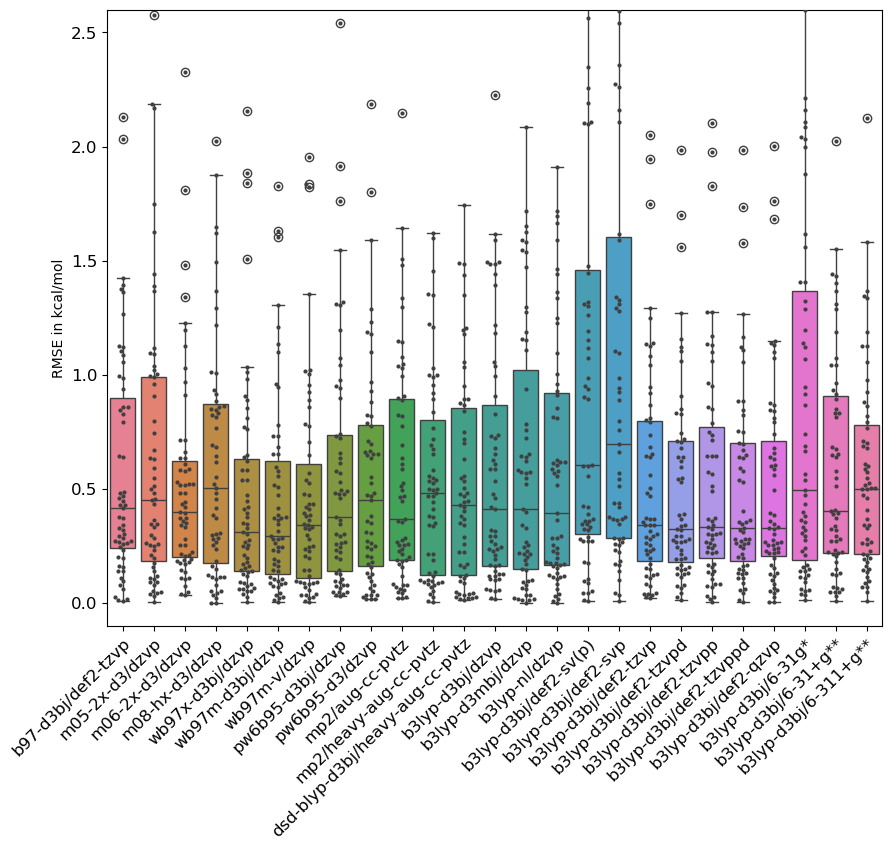

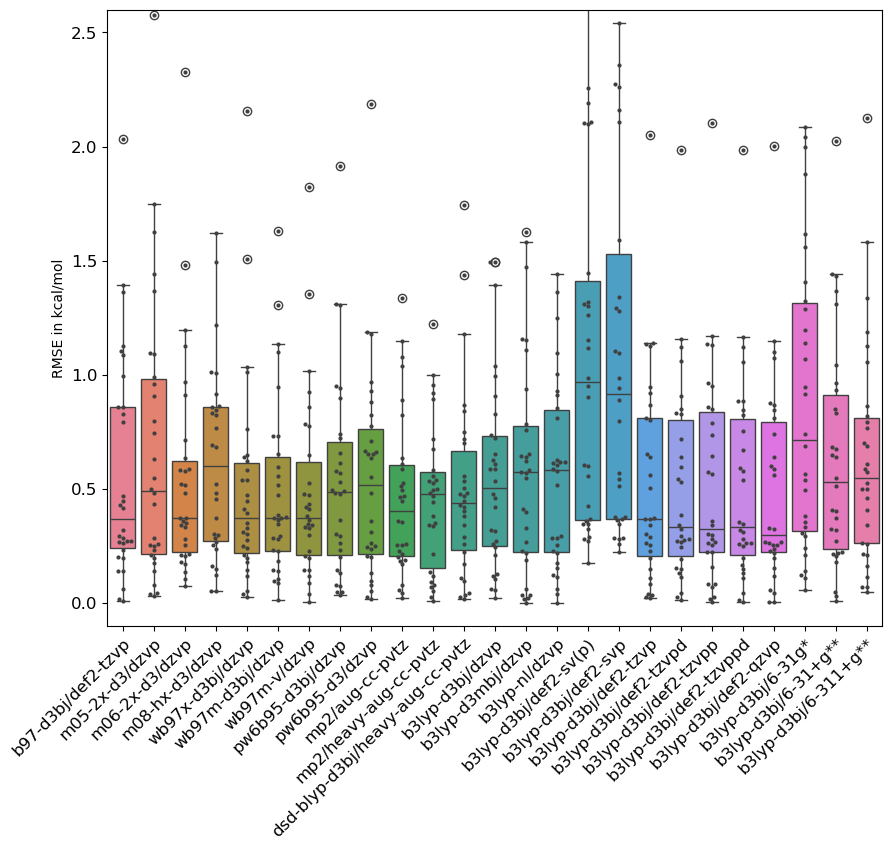

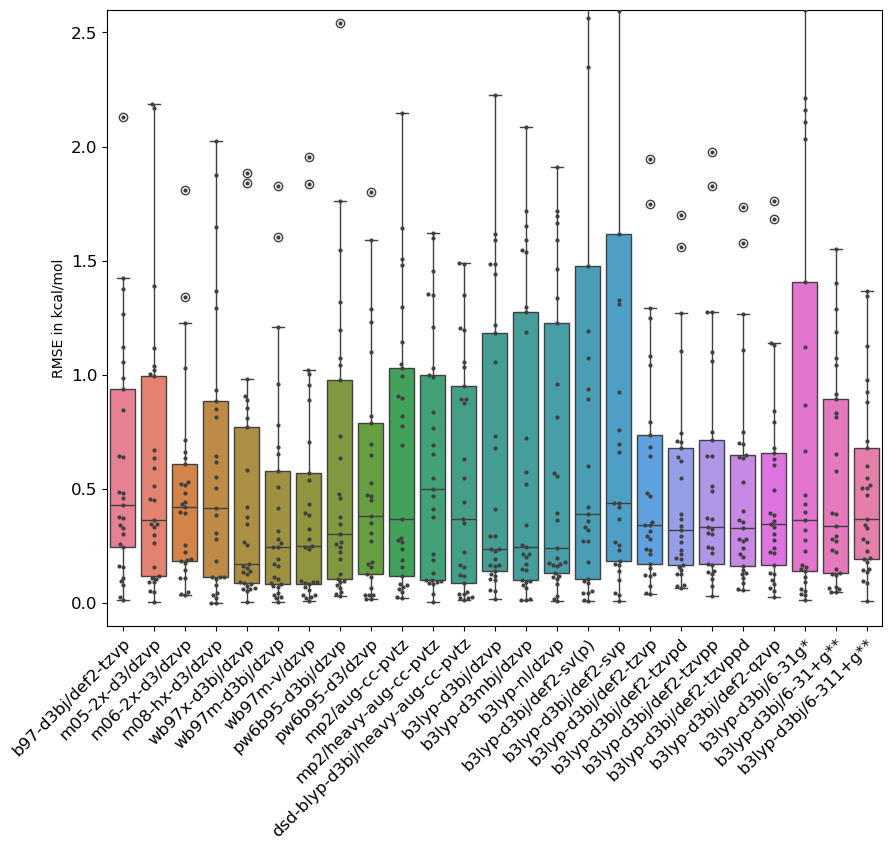

In [8]:
# RMSE, MAE
fig, ax = plt.subplots(figsize=[10, 8])
# Width of a bar
width = 0.25

tmp_df = pd.DataFrame(rmse)
df = tmp_df.T
ax = sns.boxplot(data=df)
ax = sns.swarmplot(data=df, size=3, color="0.25")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.xaxis.get_label().set_fontsize(12)
ax.set(ylabel="RMSE in kcal/mol")
ax.yaxis.get_label().set_fontsize(10)
ax.set_ylim(-0.1, 2.6)
fig = ax.get_figure()
plt.savefig('./output/rmse-all-barriers-functionals.png',dpi=600,
            bbox_inches="tight")
plt.show()
pdf.savefig(fig, dpi=600, bbox_inches="tight")


fig, ax = plt.subplots(figsize=[10, 8])
# Width of a bar
width = 0.25
tmp_df = pd.DataFrame(neutral_rmse)
df = tmp_df.T
ax = sns.boxplot(data=df)
ax = sns.swarmplot(data=df, size=3, color="0.25")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.xaxis.get_label().set_fontsize(12)
ax.set(ylabel="RMSE in kcal/mol")
ax.yaxis.get_label().set_fontsize(10)
ax.set_ylim(-0.1, 2.6)
fig = ax.get_figure()
plt.savefig('./output/neutral-rmse-barriers-b3lyp-and-basis.png',dpi=600,
            bbox_inches="tight")
plt.show()
pdf.savefig(fig, dpi=600, bbox_inches="tight")


fig, ax = plt.subplots(figsize=[10, 8])
# Width of a bar
width = 0.25
tmp_df = pd.DataFrame(charged_rmse)
df = tmp_df.T
ax = sns.boxplot(data=df)
ax = sns.swarmplot(data=df, size=3, color="0.25")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.xaxis.get_label().set_fontsize(12)
ax.set(ylabel="RMSE in kcal/mol")
ax.yaxis.get_label().set_fontsize(10)
ax.set_ylim(-0.1, 2.6)
fig = ax.get_figure()
plt.savefig('./output/charged-rmse-barriers-b3lyp-and-basis.png',dpi=600,
            bbox_inches="tight")
plt.show()
pdf.savefig(fig, dpi=600, bbox_inches="tight")

pdf.close()

In [9]:
print(
    tabulate(
        table,
        headers=["Specification", 
                 "RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "MAE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "Neutral RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "Charged RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 ],
        tablefmt="orgtbl",
    )
)
print("* closer to zero the better")

with open("./output/rmse_barrier_scores_test.txt", "w") as f:
    f.write("Using " + REF_SPEC + " as a reference method the scores are: \n")
    f.write(
        tabulate(
            table,
            headers=["Specification", "RMSE in kcal/mol", "MAE in kcal/mol"],
            tablefmt="orgtbl",
        )
    )
    f.write("\n")
    f.write("* closer to zero the better")

| Specification                   |   RMSE in kcal/mol |   low 95% ci |   high 95% ci |   MAE in kcal/mol |   low 95% ci |   high 95% ci |   Neutral RMSE in kcal/mol |   low 95% ci |   high 95% ci |   Charged RMSE in kcal/mol |   low 95% ci |   high 95% ci |
|---------------------------------+--------------------+--------------+---------------+-------------------+--------------+---------------+----------------------------+--------------+---------------+----------------------------+--------------+---------------|
| b97-d3bj/def2-tzvp              |             0.7632 |       0.605  |        0.92   |            0.5814 |       0.4568 |        0.7139 |                     0.7502 |       0.5327 |        0.9551 |                     0.7764 |       0.5638 |        0.994  |
| m05-2x-d3/dzvp                  |             0.8614 |       0.6783 |        1.0386 |            0.6284 |       0.4866 |        0.7833 |                     0.9022 |       0.641  |        1.1583 |                     0.81

In [10]:
# For latex table entries
print("RMSE Neutral Charged")
for item in table:
    print(
        f"{item[0].upper()} & ${{{item[1]}}}_{{{item[2]}}}^{{{item[3]}"
        f"}}$ & ${{{item[7]}}}_{{{item[8]}}}^{{{item[9]}}}$ & ${{{item[10]}}}_{{{item[11]}}}^{{{item[12]}}}$\\\\ \\vspace{{2mm}}")

RMSE Neutral Charged
B97-D3BJ/DEF2-TZVP & ${0.7632}_{0.6050}^{0.9200}$ & ${0.7502}_{0.5327}^{0.9551}$ & ${0.7764}_{0.5638}^{0.9940}$\\ \vspace{2mm}
M05-2X-D3/DZVP & ${0.8614}_{0.6783}^{1.0386}$ & ${0.9022}_{0.6410}^{1.1583}$ & ${0.8170}_{0.5410}^{1.0667}$\\ \vspace{2mm}
M06-2X-D3/DZVP & ${0.6823}_{0.5041}^{0.8574}$ & ${0.7280}_{0.4878}^{0.9896}$ & ${0.6316}_{0.4366}^{0.8221}$\\ \vspace{2mm}
M08-HX-D3/DZVP & ${0.9174}_{0.7053}^{1.1303}$ & ${0.8721}_{0.6153}^{1.1408}$ & ${0.9619}_{0.6176}^{1.2722}$\\ \vspace{2mm}
WB97X-D3BJ/DZVP & ${0.6614}_{0.4841}^{0.8317}$ & ${0.6640}_{0.4250}^{0.9118}$ & ${0.6587}_{0.4053}^{0.8910}$\\ \vspace{2mm}
WB97M-D3BJ/DZVP & ${0.6207}_{0.4749}^{0.7672}$ & ${0.6235}_{0.4417}^{0.8054}$ & ${0.6178}_{0.3806}^{0.8423}$\\ \vspace{2mm}
WB97M-V/DZVP & ${0.6462}_{0.4976}^{0.8098}$ & ${0.6239}_{0.4398}^{0.8086}$ & ${0.6686}_{0.4173}^{0.8949}$\\ \vspace{2mm}
PW6B95-D3BJ/DZVP & ${0.7630}_{0.5842}^{0.9414}$ & ${0.6822}_{0.4943}^{0.8665}$ & ${0.8384}_{0.5521}^{1.1027}$\\ \v

In [11]:
table_data = defaultdict(dict)
for item in table:
    table_data[item[0]] =  {'RMSE': item[1], 'RMSE_ci_high': item[3], 'RMSE_ci_low': item[2], 
                            'MUE': item[4], 'MUE_ci_high': item[6], 'MUE_ci_low': item[5], 
                            'RMSE-Neutral': item[7], 'RMSE-Neutral_ci_high': item[9], 'RMSE-Neutral_ci_low': item[8],
                            'RMSE-Charged': item[10], 'RMSE-Charged_ci_high': item[12], 'RMSE-Charged_ci_low': item[11],
                            }
                            
with open('./data/all_methods_barrier_statistics.json', 'w') as outfile:
    json.dump(table_data, outfile)